# %%[markdown]

 Author: Nelson Liu

 Email: [nliu@uncharted.software](mailto:nliu@uncharted.software)

# %%[markdown]

 # Monthly Demo (2024-08)

In [ ]:
# %%

import os
import json
import mira.metamodel
import numpy
import sympy
import pandas
import matplotlib.pyplot as plt
import matplotlib as mpl
import requests
import copy

import mira
from mira.sources import biomodels
from mira.modeling.viz import GraphicalModel
from mira.modeling.amr.petrinet import template_model_to_petrinet_json
from mira.sources.amr.petrinet import template_model_from_amr_json
from mira.dkg.web_client import is_ontological_child_web
from mira.metamodel import *
# from mira.modeling import Model

from mira.modeling.amr.ops import *
from mira.metamodel.io import expression_to_mathml


MIRA_REST_URL = "http://34.230.33.149:8771/api"

In [ ]:
# %%

# Generate summary table of a template model
def generate_summary_table(model) -> pandas.DataFrame:

    data = {"name": [t.name for t in model.templates]}
    for k in ("subject", "outcome", "controller"):
        data[k] = [getattr(t, k).name if hasattr(t, k) else None for t in model.templates]

    data["controllers"] = [[c.name for c in getattr(t, k)] if hasattr(t, "controllers") else None for t in model.templates]
    data["controller(s)"] = [i if j == None else j for i, j in zip(data["controller"], data["controllers"])]
    __ = data.pop("controller")
    __ = data.pop("controllers")

    data["rate_law"] = [t.rate_law for t in model.templates]
    data["interactor_rate_law"] = [t.get_interactor_rate_law() for t in model.templates]

    df = pandas.DataFrame(data)

    return df

# Generate initial condition and parameter tables
def generate_init_param_tables(model) -> tuple[pandas.DataFrame, pandas.DataFrame]:

    data = {}
    data["name"] = [name for name, __ in model.initials.items()]
    data["expression"] = [init.expression for __, init in model.initials.items()]
    df_initials = pandas.DataFrame(data)

    data = {}
    data["name"] = [name for name, __ in model.parameters.items()]
    data["value"] = [param.value for __, param in model.parameters.items()]
    df_params = pandas.DataFrame(data)

    return (df_initials, df_params)

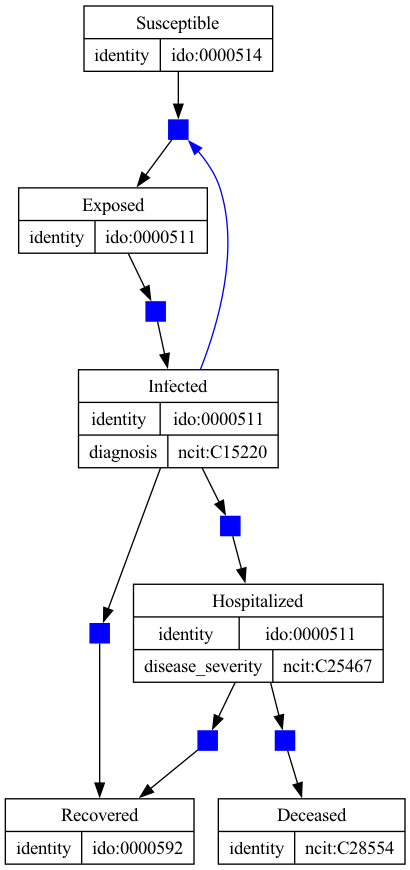

In [ ]:
# %%

with open("./data/monthly_demo_202408/model_seirhd.json", "r") as f:
    model_seirhd = template_model_from_amr_json(json.load(f))

GraphicalModel.for_jupyter(model_seirhd)

# %%[markdown]

 ## Problem 3

 12-month evaluation, scenario 2

 ### Question 1

 1. Start from the base SEIRHD model from Scenario 1
 2. Edit the rate law of the exposure/infection process to include the effects of vaccination, masking, contact
 3. Stratify only the state `S` and parameter `beta`` by vaccination status (vaccinated, unvaccinated)
 4. Stratify only the vaccinated states and  `beta`` by vaccine used (pfizer, moderna, jj)
 5. Stratify the mRNA-vaccinated states and beta by the number of doses (1, 2nd same, 2nd difference)
 6. Remove all 0-2 dose transitions

In [ ]:
# %%

# Add a masking-effect factor `m` to the exposure process (S -> E controlled by I)
model_seirhd_effect = copy.deepcopy(model_seirhd)
model_seirhd_effect.add_parameter(
    "v", "v", "Vaccine efficacy effect on the disease exposure process (0 = complete efficacy, 1 = no efficacy)", 1.0
)
model_seirhd_effect.add_parameter(
    "m", "m", "Masking effect on the disease exposure process (0 = unmasked, 1 = fully masked)", 0.0
)
model_seirhd_effect.add_parameter(
    "c", "c", "Contact effect on the disease exposure process (0 = no contact, 1 = full contact)", 1.0
)

# Find the exposure transition
id = [template.name for template in model_seirhd_effect.templates if (template.subject.name == "S") & (template.outcome.name == "E")][0]

# Change its rate law
amr = template_model_to_petrinet_json(model_seirhd_effect)
amr = replace_rate_law_sympy(amr, id, sympy.Symbol("c") * (1 - sympy.Symbol("m")) * sympy.Symbol("v") * sympy.Symbol("b") * sympy.Symbol("invN") * sympy.Symbol("S") * sympy.Symbol("I"))
model_seirhd_effect = template_model_from_amr_json(amr)

# Check
generate_summary_table(model_seirhd_effect)

,name,subject,outcome,controller(s),rate_law,interactor_rate_law
0,t1,S,E,I,I*S*b*c*invN*v*(1 - m),I*S
1,t5,E,I,None,E*rEI,E
2,t9,I,R,None,I*pIR*rIR,I
3,t15,H,D,None,H*pHD*rHD,H
4,t16,H,R,None,H*pHR*rHR,H
5,t17,I,H,None,I*pIH*rIH,I


In [ ]:
# %%

model_seirhd_effect.annotations.name = "SEIRHD model with effects"
model_seirhd_effect.annotations.description = "Edit of the SEIRHD model with effect parameters on the exposure process"

# Save
with open("./data/monthly_demo_202408/model_seirhd_effect.json", "w") as f:
    json.dump(template_model_to_petrinet_json(model_seirhd_effect), f, indent = 4)

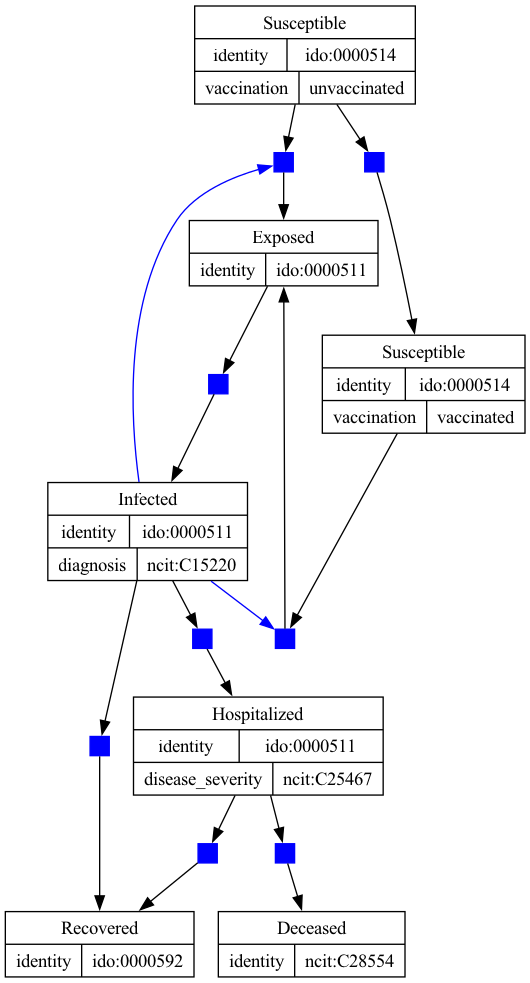

In [ ]:
# %%

# Stratify by vaccination status
# * only unvaccinated -> vaccinated is permitted
# * only the infection rate `beta` and masking effect `m`
# * only for S, E, I

model_seirhd_effect_vacc = mira.metamodel.stratify(
    model_seirhd_effect,
    key = "vaccination",
    strata = ["unvaccinated", "vaccinated"],
    structure = [["unvaccinated", "vaccinated"]],
    directed = True,
    cartesian_control = False, 
    concepts_to_stratify = {"S"},
    params_to_stratify = {"v", "m"},
    param_renaming_uses_strata_names = True
)

GraphicalModel.for_jupyter(model_seirhd_effect_vacc)

In [ ]:
# %%

generate_summary_table(model_seirhd_effect_vacc)

,name,subject,outcome,controller(s),rate_law,interactor_rate_law
0,t1_unvaccinated,S_unvaccinated,E,I,I*S_unvaccinated*b*c*invN*v_unvaccinated*(1 - ...,I*S_unvaccinated
1,t1_vaccinated,S_vaccinated,E,I,I*S_vaccinated*b*c*invN*v_vaccinated*(1 - m_va...,I*S_vaccinated
2,t5,E,I,None,E*rEI,E
3,t9,I,R,None,I*pIR*rIR,I
4,t15,H,D,None,H*pHD*rHD,H
5,t16,H,R,None,H*pHR*rHR,H
6,t17,I,H,None,I*pIH*rIH,I
7,t_conv_0_unvaccinated_vaccinated,S_unvaccinated,S_vaccinated,None,S_unvaccinated*p_unvaccinated_vaccinated,S_unvaccinated


In [ ]:
# %%

generate_init_param_tables(model_seirhd_effect_vacc)[0]

,name,expression
0,S_unvaccinated,S0/2
1,S_vaccinated,S0/2
2,I,I0
3,E,E0
4,R,R0
5,H,H0
6,D,D0


In [ ]:
# %%

generate_init_param_tables(model_seirhd_effect_vacc)[1]

,name,value
0,b,4.000000e-01
1,c,1.000000e+00
2,invN,5.170631e-08
3,m_unvaccinated,0.000000e+00
4,m_vaccinated,0.000000e+00
5,v_unvaccinated,1.000000e+00
6,v_vaccinated,1.000000e+00
7,rEI,2.000000e-01
8,pIR,8.000000e-01
9,rIR,7.000000e-02


In [ ]:
# %%

model_seirhd_effect_vacc.annotations.name = "SEIRHD model with effects (vaccination)"
model_seirhd_effect_vacc.annotations.description = "Edit of the SEIRHD model with effect parameters on the exposure process"

# Save
with open("./data/monthly_demo_202408/model_seirhd_effect_vacc.json", "w") as f:
    json.dump(template_model_to_petrinet_json(model_seirhd_effect_vacc), f, indent = 4)

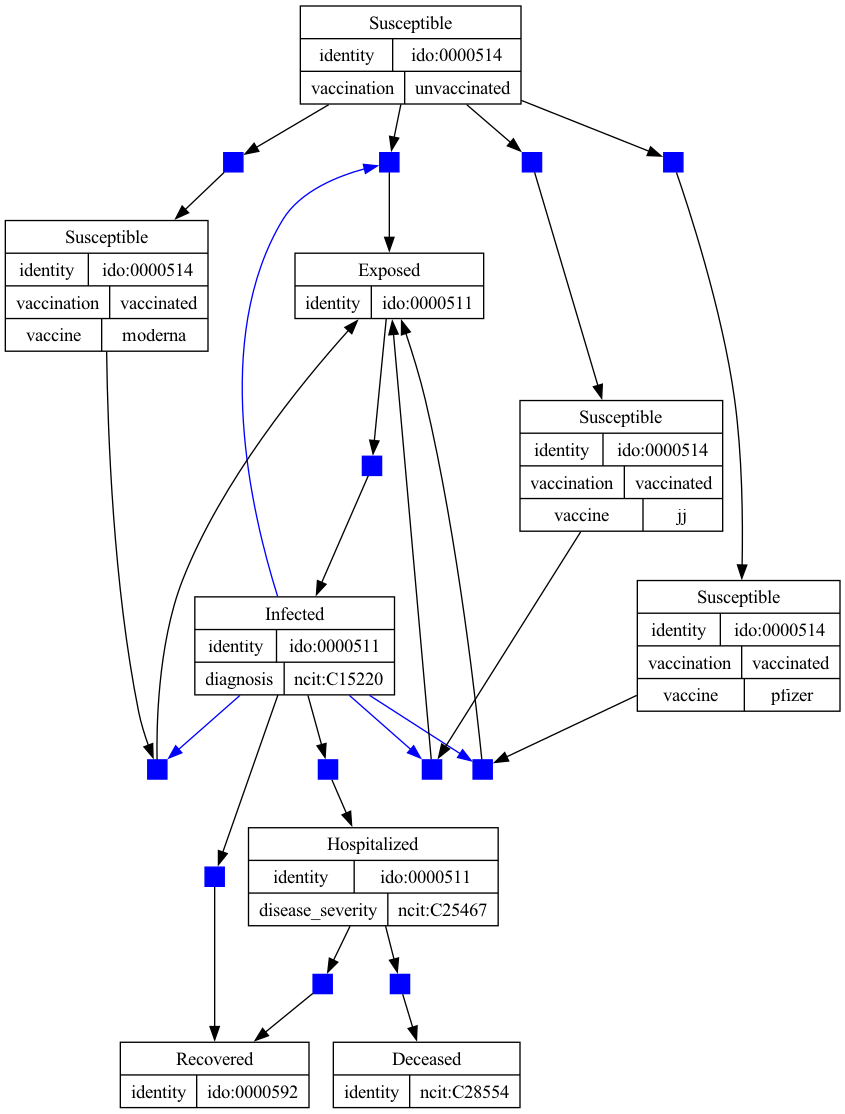

In [ ]:
# %%

# Stratify by vaccine used in vaccination
# * only vaccinated pops
# * only vaccine efficacy (v_*) and vaccination rate (p)

concepts_to_stratify = {
    c.name 
    for c in model_seirhd_effect_vacc.get_concepts_name_map().values() 
    if c.name.endswith("_vaccinated")
}
params_to_stratify = {
    p 
    for p in model_seirhd_effect_vacc.parameters.keys()
    if p.startswith("v_") or p.startswith("p")
}

model_seirhd_effect_vacc2 = mira.metamodel.stratify(
    model_seirhd_effect_vacc,
    key = "vaccine",
    strata = ["pfizer", "moderna", "jj"],
    structure = [],
    directed = True,
    cartesian_control = False,
    concepts_to_stratify = concepts_to_stratify,
    params_to_stratify = params_to_stratify,
    param_renaming_uses_strata_names = True
)

GraphicalModel.for_jupyter(model_seirhd_effect_vacc2)

In [ ]:
# %%

generate_summary_table(model_seirhd_effect_vacc2)

,name,subject,outcome,controller(s),rate_law,interactor_rate_law
0,t1_unvaccinated,S_unvaccinated,E,I,I*S_unvaccinated*b*c*invN*v_unvaccinated*(1 - ...,I*S_unvaccinated
1,t1_vaccinated_pfizer,S_vaccinated_pfizer,E,I,I*S_vaccinated_pfizer*b*c*invN*v_vaccinated_pf...,I*S_vaccinated_pfizer
2,t1_vaccinated_moderna,S_vaccinated_moderna,E,I,I*S_vaccinated_moderna*b*c*invN*v_vaccinated_m...,I*S_vaccinated_moderna
3,t1_vaccinated_jj,S_vaccinated_jj,E,I,I*S_vaccinated_jj*b*c*invN*v_vaccinated_jj*(1 ...,I*S_vaccinated_jj
4,t5,E,I,None,E*rEI,E
5,t9,I,R,None,I*pIR*rIR,I
6,t15,H,D,None,H*pHD*rHD,H
7,t16,H,R,None,H*pHR*rHR,H
8,t17,I,H,None,I*pIH*rIH,I
9,t_conv_0_unvaccinated_vaccinated_pfizer,S_unvaccinated,S_vaccinated_pfizer,None,S_unvaccinated*p_unvaccinated_vaccinated_pfizer,S_unvaccinated


In [ ]:
# %%

generate_init_param_tables(model_seirhd_effect_vacc2)[0]

,name,expression
0,S_unvaccinated,S0/2
1,S_vaccinated_pfizer,S0/6
2,S_vaccinated_moderna,S0/6
3,S_vaccinated_jj,S0/6
4,I,I0
5,E,E0
6,R,R0
7,H,H0
8,D,D0


In [ ]:
# %%

generate_init_param_tables(model_seirhd_effect_vacc2)[1]

,name,value
0,b,4.000000e-01
1,c,1.000000e+00
2,invN,5.170631e-08
3,m_unvaccinated,0.000000e+00
4,m_vaccinated,0.000000e+00
5,v_unvaccinated,1.000000e+00
6,v_vaccinated_jj,1.000000e+00
7,v_vaccinated_moderna,1.000000e+00
8,v_vaccinated_pfizer,1.000000e+00
9,rEI,2.000000e-01


In [ ]:
# %%

model_seirhd_effect_vacc2.annotations.name = "SEIRHD model with effects (vaccination, vaccine brands)"
model_seirhd_effect_vacc2.annotations.description = "Edit of the SEIRHD model with effect parameters on the exposure process"

# Save
with open("./data/monthly_demo_202408/model_seirhd_effect_vacc2.json", "w") as f:
    json.dump(template_model_to_petrinet_json(model_seirhd_effect_vacc2), f, indent = 4)

In [ ]:
# %%

# Stratify by the number of vaccine doses
# * only mRNA-vaccinated pops (S_vaccinated_moderna, S_vaccinated_pfizer)
# * only vaccine efficacy "v_vaccinated*" and vaccination rate "p_*"
# * one dose, two dose, different second dose

concepts_to_stratify = {
    c.name 
    for c in model_seirhd_effect_vacc2.get_concepts_name_map().values() 
    if c.name.startswith(("S_vaccinated_pfizer")) or c.name.startswith("S_vaccinated_moderna")
}

params_to_stratify = {
    p 
    for p in model_seirhd_effect_vacc2.parameters.keys()
    if p.startswith("v_vaccinated")
}

model_seirhd_effect_vacc2_dose = mira.metamodel.stratify(
    model_seirhd_effect_vacc2,
    key = "dose",
    strata = ["one", "two", "diff"],
    structure = [["one", "two"], ["one", "diff"]],
    directed = True,
    cartesian_control = False,
    concepts_to_stratify = concepts_to_stratify,
    params_to_stratify = params_to_stratify,
    param_renaming_uses_strata_names = True
)

In [ ]:
# %%

# # Second dose of vaccination
# amr = template_model_to_petrinet_json(model_seirhd_effect_vacc2)
# amr = add_transition(
#     amr, 
#     new_transition_id = "VaccinationProcess2", 
#     src_id = "S_vaccinated", 
#     tgt_id = "S_vaccinated", 
#     rate_law_mathml = expression_to_mathml(sympy.Symbol("v") * sympy.Symbol("S_unvaccinated")),
#     params_dict = {
#         "v": {"value": 0.01, "description": "Vaccination rate of susceptible persons"}
#     }
# )
# model_seirhd_effect_vacc2 = template_model_from_amr_json(amr)

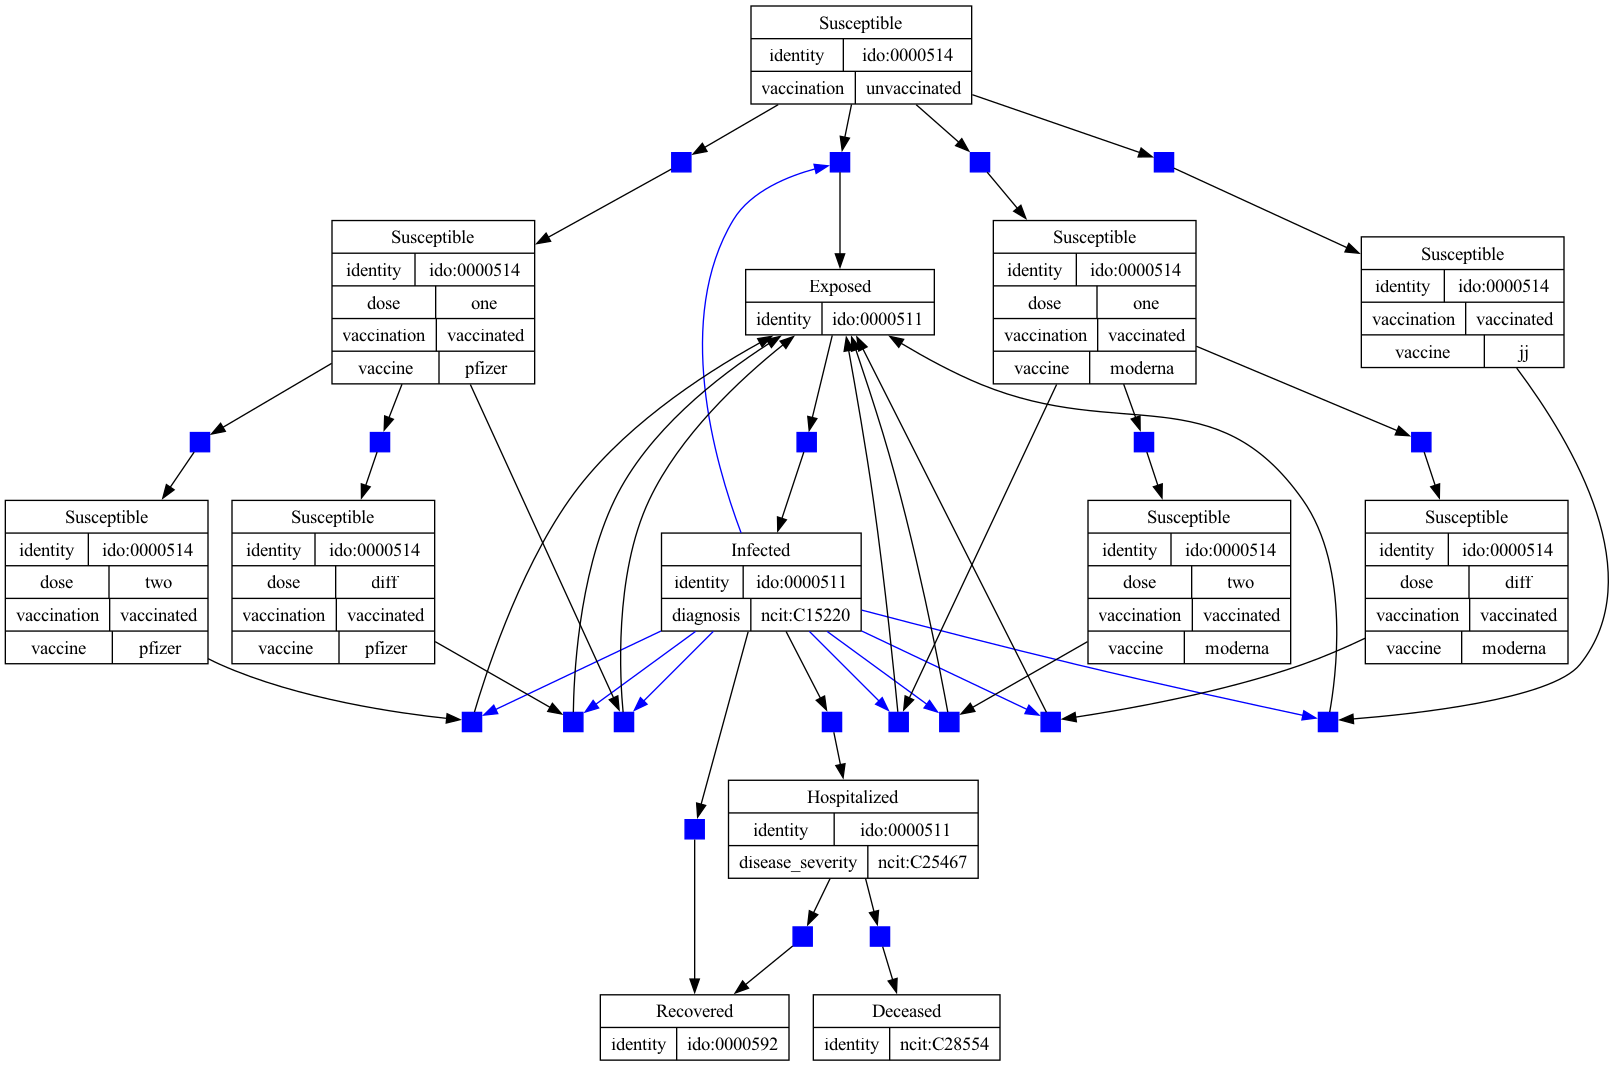

In [ ]:
# %%

# Remove forbidden transitions:
# * unvaccinated -> 2 doses of any vaccine (*_two, *_diff)

forbidden_transition_ids = [t.name 
    for t in model_seirhd_effect_vacc2_dose.templates 
    if isinstance(t, NaturalConversion)
        and t.subject.name.endswith("unvaccinated") 
        and (t.outcome.name.endswith("two") or t.outcome.name.endswith("diff"))
]

amr = template_model_to_petrinet_json(model_seirhd_effect_vacc2_dose)
for t in model_seirhd_effect_vacc2_dose.templates:
    if t.name in forbidden_transition_ids:
        amr = remove_transition(amr, transition_id = t.name)

model_seirhd_effect_vacc2_dose = template_model_from_amr_json(amr)

GraphicalModel.for_jupyter(model_seirhd_effect_vacc2_dose)

In [ ]:
# %%

generate_summary_table(model_seirhd_effect_vacc2_dose)

,name,subject,outcome,controller(s),rate_law,interactor_rate_law
0,t1_unvaccinated,S_unvaccinated,E,I,I*S_unvaccinated*b*c*invN*v_unvaccinated*(1 - ...,I*S_unvaccinated
1,t1_vaccinated_pfizer_one,S_vaccinated_pfizer_one,E,I,I*S_vaccinated_pfizer_one*b*c*invN*v_vaccinate...,I*S_vaccinated_pfizer_one
2,t1_vaccinated_pfizer_two,S_vaccinated_pfizer_two,E,I,I*S_vaccinated_pfizer_two*b*c*invN*v_vaccinate...,I*S_vaccinated_pfizer_two
3,t1_vaccinated_pfizer_diff,S_vaccinated_pfizer_diff,E,I,I*S_vaccinated_pfizer_diff*b*c*invN*v_vaccinat...,I*S_vaccinated_pfizer_diff
4,t1_vaccinated_moderna_one,S_vaccinated_moderna_one,E,I,I*S_vaccinated_moderna_one*b*c*invN*v_vaccinat...,I*S_vaccinated_moderna_one
5,t1_vaccinated_moderna_two,S_vaccinated_moderna_two,E,I,I*S_vaccinated_moderna_two*b*c*invN*v_vaccinat...,I*S_vaccinated_moderna_two
6,t1_vaccinated_moderna_diff,S_vaccinated_moderna_diff,E,I,I*S_vaccinated_moderna_diff*b*c*invN*v_vaccina...,I*S_vaccinated_moderna_diff
7,t1_vaccinated_jj,S_vaccinated_jj,E,I,I*S_vaccinated_jj*b*c*invN*v_vaccinated_jj*(1 ...,I*S_vaccinated_jj
8,t5,E,I,None,E*rEI,E
9,t9,I,R,None,I*pIR*rIR,I


In [ ]:
# %%

generate_init_param_tables(model_seirhd_effect_vacc2_dose)[0]

,name,expression
0,S_unvaccinated,S0/2
1,I,I0
2,E,E0
3,S_vaccinated_pfizer_one,S0/18
4,S_vaccinated_pfizer_two,S0/18
5,S_vaccinated_pfizer_diff,S0/18
6,S_vaccinated_moderna_one,S0/18
7,S_vaccinated_moderna_two,S0/18
8,S_vaccinated_moderna_diff,S0/18
9,S_vaccinated_jj,S0/6


In [ ]:
# %%

generate_init_param_tables(model_seirhd_effect_vacc2_dose)[1]

,name,value
0,b,4.000000e-01
1,c,1.000000e+00
2,invN,5.170631e-08
3,m_unvaccinated,0.000000e+00
4,v_unvaccinated,1.000000e+00
5,m_vaccinated,0.000000e+00
6,v_vaccinated_pfizer_one,1.000000e+00
7,v_vaccinated_pfizer_two,1.000000e+00
8,v_vaccinated_pfizer_diff,1.000000e+00
9,v_vaccinated_moderna_one,1.000000e+00


In [ ]:
# %%

model_seirhd_effect_vacc2_dose.annotations.name = "SEIRHD model with effects (vaccination, vaccine brands, doses)"
model_seirhd_effect_vacc2_dose.annotations.description = "Edit of the SEIRHD model with effect parameters on the exposure process"

# Save
with open("./data/monthly_demo_202408/model_seirhd_effect_vacc2_dose.json", "w") as f:
    json.dump(template_model_to_petrinet_json(model_seirhd_effect_vacc2_dose), f, indent = 4)

# %%[markdown]

 ### Question 2

 1. Start from the final SEIRHD model from above
 2. Stratify all states (except `D`) by three age groups ("0to9", "10to19", "20above")
 3. Preserve the `v`, `invN`, `r**` parameters
 4. Remove all vaccination processes and vaccinated states associated with the age group "0to9"

In [ ]:
# %%

params_to_preserve = {
    p 
    for p in model_seirhd_effect_vacc2_dose.parameters.keys()
    if (p in ("b", "invN")) or p.startswith("v_") or p.startswith("r")
}

model_seirhd_effect_vacc2_dose_age = mira.metamodel.stratify(
    model_seirhd_effect_vacc2_dose,
    key = "age",
    strata = ["0to9", "10to19", "20above"],
    structure = [],
    directed = True,
    cartesian_control = True,
    concepts_to_preserve = {"D"},
    params_to_preserve = params_to_preserve,
    param_renaming_uses_strata_names = True
)

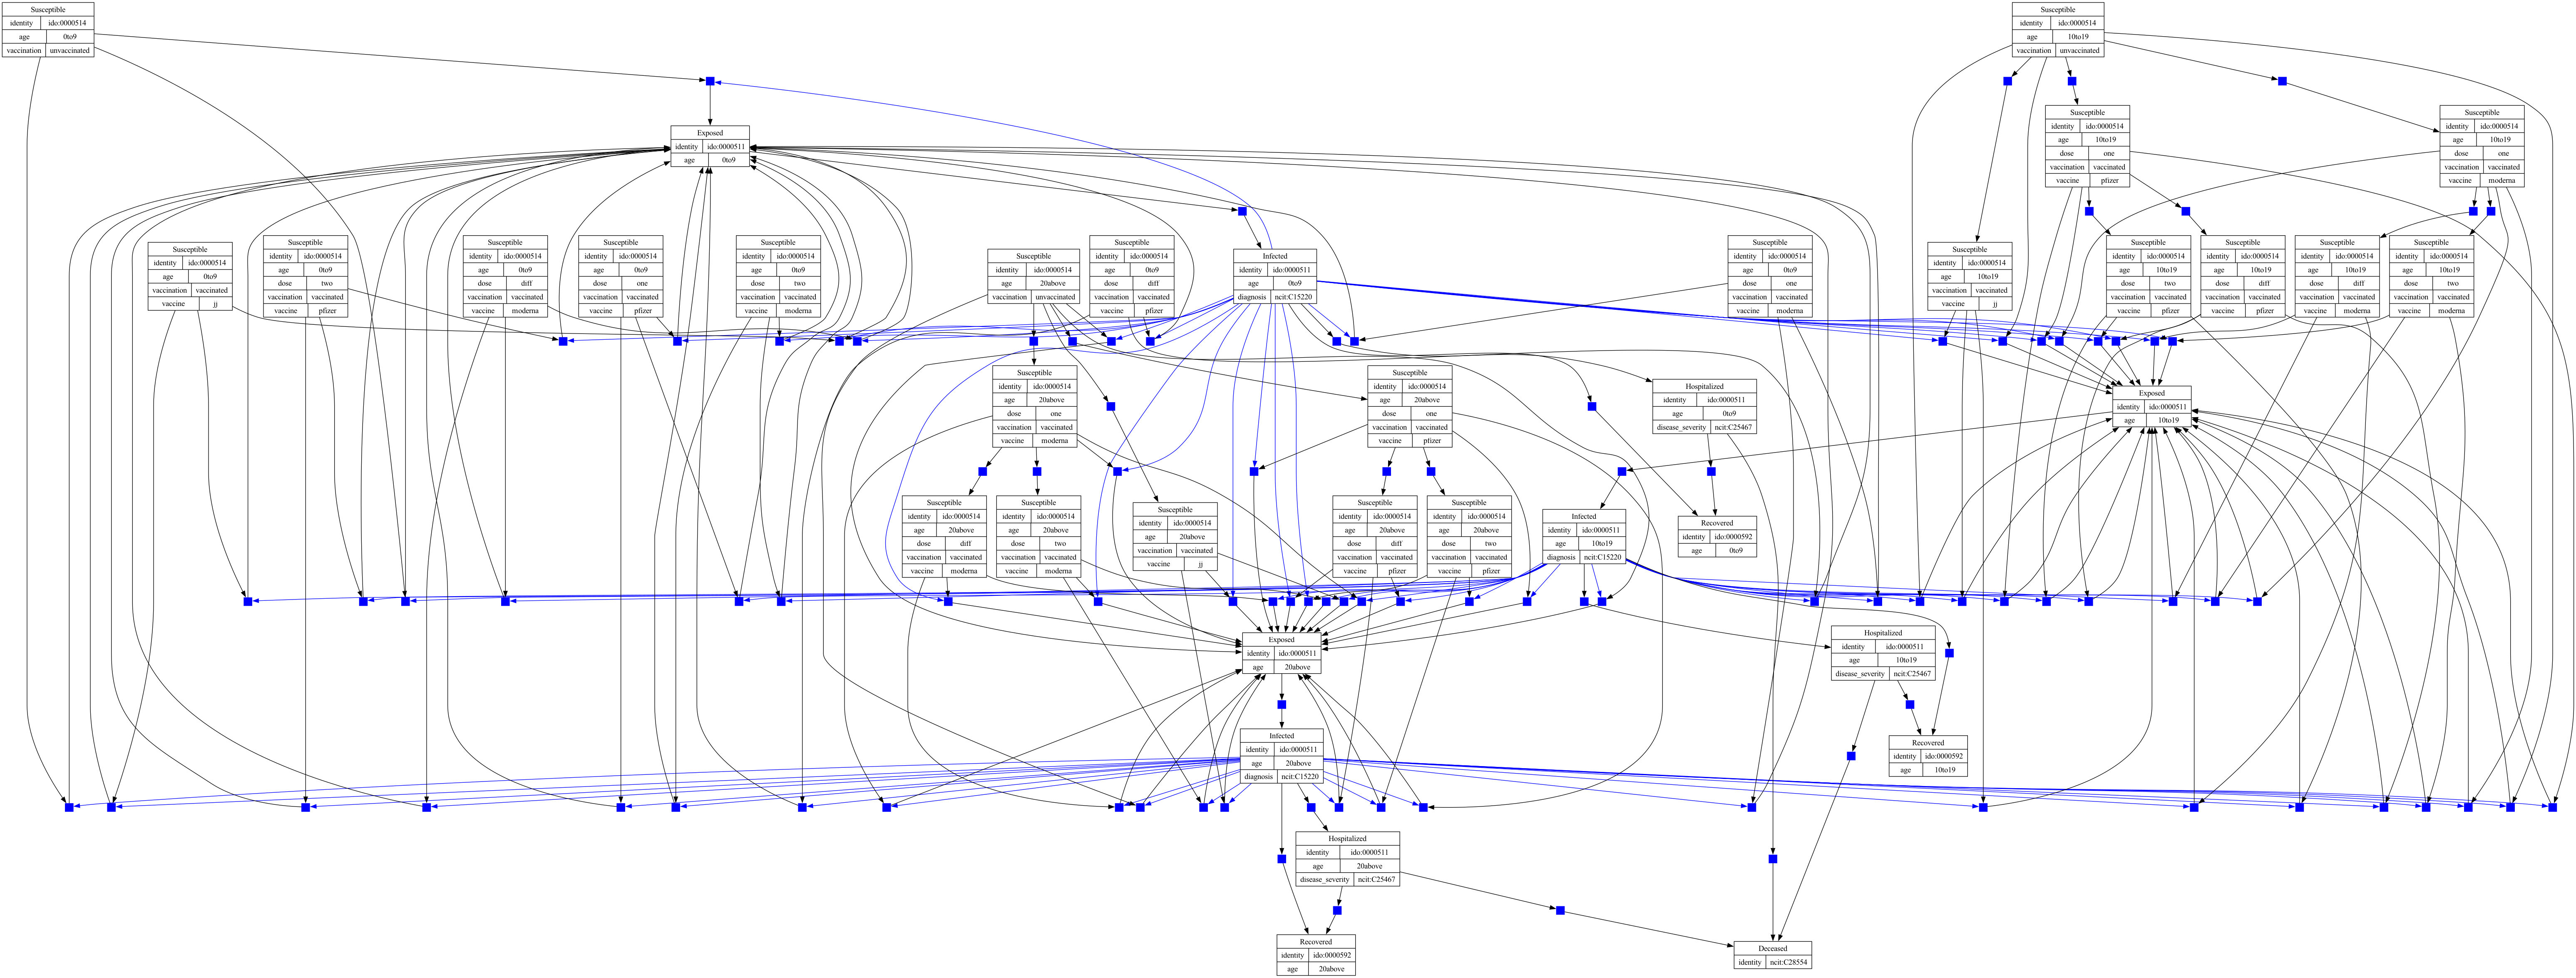

In [ ]:
# %%

# Remove all vaccination processes associated with age group "0to9"
forbidden_transition_ids = [t.name 
    for t in model_seirhd_effect_vacc2_dose_age.templates 
    if isinstance(t, NaturalConversion)
        and t.subject.name.endswith("0to9") 
        and t.outcome.name.startswith("S_vaccinated")
]

amr = template_model_to_petrinet_json(model_seirhd_effect_vacc2_dose_age)
for t in model_seirhd_effect_vacc2_dose_age.templates:
    if t.name in forbidden_transition_ids:
        amr = remove_transition(amr, transition_id = t.name)

model_seirhd_effect_vacc2_dose_age = template_model_from_amr_json(amr)

GraphicalModel.for_jupyter(model_seirhd_effect_vacc2_dose_age)

In [ ]:
# %%

generate_summary_table(model_seirhd_effect_vacc2_dose_age)

,name,subject,outcome,controller(s),rate_law,interactor_rate_law
0,t1_unvaccinated_0to9_0to9,S_unvaccinated_0to9,E_0to9,I_0to9,I_0to9*S_unvaccinated_0to9*b*c_0to9_0to9*invN*...,I_0to9*S_unvaccinated_0to9
1,t1_unvaccinated_0to9_10to19,S_unvaccinated_0to9,E_0to9,I_10to19,I_10to19*S_unvaccinated_0to9*b*c_0to9_10to19*i...,I_10to19*S_unvaccinated_0to9
2,t1_unvaccinated_0to9_20above,S_unvaccinated_0to9,E_0to9,I_20above,I_20above*S_unvaccinated_0to9*b*c_0to9_20above...,I_20above*S_unvaccinated_0to9
3,t1_unvaccinated_10to19_0to9,S_unvaccinated_10to19,E_10to19,I_0to9,I_0to9*S_unvaccinated_10to19*b*c_10to19_0to9*i...,I_0to9*S_unvaccinated_10to19
4,t1_unvaccinated_10to19_10to19,S_unvaccinated_10to19,E_10to19,I_10to19,I_10to19*S_unvaccinated_10to19*b*c_10to19_10to...,I_10to19*S_unvaccinated_10to19
...,...,...,...,...,...,...
96,t_conv_4_one_two_20above,S_vaccinated_moderna_one_20above,S_vaccinated_moderna_two_20above,None,S_vaccinated_moderna_one_20above*p_one_two_20a...,S_vaccinated_moderna_one_20above
97,t_conv_12_one_diff_10to19,S_vaccinated_pfizer_one_10to19,S_vaccinated_pfizer_diff_10to19,None,S_vaccinated_pfizer_one_10to19*p_one_diff_10to19,S_vaccinated_pfizer_one_10to19
98,t_conv_12_one_diff_20above,S_vaccinated_pfizer_one_20above,S_vaccinated_pfizer_diff_20above,None,S_vaccinated_pfizer_one_20above*p_one_diff_20a...,S_vaccinated_pfizer_one_20above
99,t_conv_13_one_diff_10to19,S_vaccinated_moderna_one_10to19,S_vaccinated_moderna_diff_10to19,None,S_vaccinated_moderna_one_10to19*p_one_diff_10to19,S_vaccinated_moderna_one_10to19


In [ ]:
# %%

generate_init_param_tables(model_seirhd_effect_vacc2_dose_age)[0]

,name,expression
0,S_unvaccinated_0to9,S0/6
1,I_0to9,I0/3
2,E_0to9,E0/3
3,I_10to19,I0/3
4,I_20above,I0/3
5,S_unvaccinated_10to19,S0/6
6,E_10to19,E0/3
7,S_unvaccinated_20above,S0/6
8,E_20above,E0/3
9,S_vaccinated_pfizer_one_0to9,S0/54


In [ ]:
# %%

generate_init_param_tables(model_seirhd_effect_vacc2_dose_age)[1]

,name,value
0,b,4.000000e-01
1,c_0to9_0to9,1.000000e+00
2,invN,5.170631e-08
3,m_unvaccinated_0to9_0to9,0.000000e+00
4,v_unvaccinated,1.000000e+00
...,...,...
70,E0,2.195500e+04
71,I0,8.782000e+04
72,R0,9.982100e+04
73,H0,1.263700e+04


In [ ]:
# %%

model_seirhd_effect_vacc2_dose_age.annotations.name = "SEIRHD model with effects (vaccination, vaccine brands, doses, age contacts)"
model_seirhd_effect_vacc2_dose_age.annotations.description = "Edit of the SEIRHD model with effect parameters on the exposure process"

# Save
with open("./data/monthly_demo_202408/model_seirhd_effect_vacc2_dose_age.json", "w") as f:
    json.dump(template_model_to_petrinet_json(model_seirhd_effect_vacc2_dose_age), f, indent = 4)